In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import os
from supervised.automl import AutoML
import category_encoders as ce
import math

# visualization
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from category_encoders import TargetEncoder
from sklearn.metrics import median_absolute_error
print('Imported sci-kit learn and AutoML libraries!')

Imported sci-kit learn and AutoML libraries!


## Let's test TPOT AutoML on our UK dataset now

We had our best results here for our Dublin data, but had very poor results on our Cork data. This will give us a better idea of how better suited our model is to larger cities potentially.

In [2]:
irl =  pd.read_csv('leefourfeatures.csv', index_col = 'Unnamed: 0')

In [3]:
irl.shape

(40943, 23)

In [4]:
irl.drop(columns = ['Transaction unique identifier', 'Town/City', 'Add1', 'HouseNum', 'geocode'], inplace = True)

In [5]:
irl = irl.dropna()

In [6]:
irl.shape

(40925, 18)

In [7]:
dt = list(irl['Postcode'])
ps = []
for i in range(len(dt)):
    strg = dt[i][:4]
    ps.append(strg)

In [8]:
irl['Postcode'] = ps

In [9]:
irl.head()

,Price,Postcode,Property Type,Old/New,Duration,Add2,Add3,District,County,PPDCategory Type,Month,Year,Latitude,Longitude,PrimaryDistance,SecondaryDistance,CityCenterDist,ClosestPitch
0,210000,LS25,D,N,F,BOND INGS RISE,SHERBURN IN ELMET,SELBY,NORTH YORKSHIRE,A,5,2017,53.79569,-1.24147,5.687375,9.790351,19.867540,7.816178
1,180000,LS25,D,N,F,RUDSTONE GROVE,SHERBURN IN ELMET,SELBY,NORTH YORKSHIRE,A,4,2017,53.79803,-1.25588,4.756776,8.873555,18.921777,6.864786
2,142500,LS19,F,Y,L,DYEHOUSE WALK,YEADON,LEEDS,WEST YORKSHIRE,A,12,2017,53.85906,-1.68457,0.419900,0.252955,11.584182,0.514805
3,102000,LS18,F,N,L,SUSSEX AVENUE,HORSFORTH,LEEDS,WEST YORKSHIRE,A,12,2017,53.84793,-1.63152,0.666159,0.892213,8.140415,0.287203
4,250000,LS19,S,Y,F,WEAVERS BECK WAY,YEADON,LEEDS,WEST YORKSHIRE,A,9,2017,53.85909,-1.68380,0.419576,0.237613,11.545989,0.537182


In [10]:
# this function finds all values that fall within internationally accepted +-10% of actual prices in our predictions
# we can modify the threshold as we feel the need to here
def accuracy_threshold(test, pred, num):
    test = np.array(test)
    pred = np.array(pred)
# get within x% of actual price , not within log price as this will be misleading / incorrect
    test = np.exp(test)
    pred = np.exp(pred)
    count = 0
    for i in range(len(pred)):
        if test[i] != 0:  
            ten = test[i] * num
            res = test[i] - pred[i]
        else:
            res = 0
            ten = 0
        
        if res < 0:
            res = res * -1
        else:
            res = res
            
        if res <= ten:
            count += 1
        else:
            continue
    return (count / len(test))

In [11]:
encoder = TargetEncoder()
irl['Add3'] = encoder.fit_transform(irl['Add3'], irl['Price'])

In [12]:
encoder = TargetEncoder()
irl['District'] = encoder.fit_transform(irl['District'], irl['Price'])

In [13]:
encoder = TargetEncoder()
irl['County'] = encoder.fit_transform(irl['County'], irl['Price'])

In [14]:
encoder = TargetEncoder()
irl['Postcode'] = encoder.fit_transform(irl['Postcode'], irl['Price'])

In [15]:
encoder = TargetEncoder()
irl['Add2'] = encoder.fit_transform(irl['Add2'], irl['Price'])

In [16]:
#categorical data
categorical_cols = ['Property Type', 'Old/New', 'Duration', 'PPDCategory Type'] 

#import pandas as pd
df = pd.get_dummies(irl, columns = categorical_cols)

In [17]:
df.columns

Index(['Price', 'Postcode', 'Add2', 'Add3', 'District', 'County', 'Month',
       'Year', 'Latitude', 'Longitude', 'PrimaryDistance', 'SecondaryDistance',
       'CityCenterDist', 'ClosestPitch', 'Property Type_D', 'Property Type_F',
       'Property Type_O', 'Property Type_S', 'Property Type_T', 'Old/New_N',
       'Old/New_Y', 'Duration_F', 'Duration_L', 'PPDCategory Type_A',
       'PPDCategory Type_B'],
      dtype='object')

In [18]:
irl = df

In [19]:
irl.head()

,Price,Postcode,Add2,Add3,District,County,Month,Year,Latitude,Longitude,...,Property Type_F,Property Type_O,Property Type_S,Property Type_T,Old/New_N,Old/New_Y,Duration_F,Duration_L,PPDCategory Type_A,PPDCategory Type_B
0,210000,217630.968385,258739.196082,224647.939686,235254.601253,256030.890142,5,2017,53.79569,-1.24147,...,0,0,0,0,1,0,1,0,1,0
1,180000,217630.968385,205494.667996,224647.939686,235254.601253,256030.890142,4,2017,53.79803,-1.25588,...,0,0,0,0,1,0,1,0,1,0
2,142500,230484.114908,243485.169492,202537.379451,230202.181727,230200.817112,12,2017,53.85906,-1.68457,...,1,0,0,0,0,1,0,1,1,0
3,102000,278963.485067,186296.875000,278963.485067,230202.181727,230200.817112,12,2017,53.84793,-1.63152,...,1,0,0,0,1,0,0,1,1,0
4,250000,230484.114908,254714.655953,202537.379451,230202.181727,230200.817112,9,2017,53.85909,-1.68380,...,0,0,1,0,0,1,1,0,1,0


In [20]:
irl['LogPrice (€)'] = np.log(irl['Price'])
irl.drop(columns = ['Price'], inplace = True)
irl.head()

,Postcode,Add2,Add3,District,County,Month,Year,Latitude,Longitude,PrimaryDistance,...,Property Type_O,Property Type_S,Property Type_T,Old/New_N,Old/New_Y,Duration_F,Duration_L,PPDCategory Type_A,PPDCategory Type_B,LogPrice (€)
0,217630.968385,258739.196082,224647.939686,235254.601253,256030.890142,5,2017,53.79569,-1.24147,5.687375,...,0,0,0,1,0,1,0,1,0,12.254863
1,217630.968385,205494.667996,224647.939686,235254.601253,256030.890142,4,2017,53.79803,-1.25588,4.756776,...,0,0,0,1,0,1,0,1,0,12.100712
2,230484.114908,243485.169492,202537.379451,230202.181727,230200.817112,12,2017,53.85906,-1.68457,0.419900,...,0,0,0,0,1,0,1,1,0,11.867097
3,278963.485067,186296.875000,278963.485067,230202.181727,230200.817112,12,2017,53.84793,-1.63152,0.666159,...,0,0,0,1,0,0,1,1,0,11.532728
4,230484.114908,254714.655953,202537.379451,230202.181727,230200.817112,9,2017,53.85909,-1.68380,0.419576,...,0,1,0,0,1,1,0,1,0,12.429216


In [21]:
from tpot import TPOTRegressor
from sklearn.model_selection import RepeatedKFold

## 2021

### TPOT

In [22]:
specific21 = irl[irl['Year'] > 2017]

In [23]:
train_21 = specific21[specific21['Year'] < 2021]

In [24]:
test_21 = specific21[specific21['Year'] == 2021]

In [25]:
x_train_21 = train_21.loc[:, train_21.columns != 'LogPrice (€)']
y_train_21 = train_21['LogPrice (€)']

In [26]:
x_test_21 = test_21.loc[:, test_21.columns != 'LogPrice (€)']
y_test_21 = test_21['LogPrice (€)']

In [27]:
x_t_21 = x_test_21

In [28]:
#cv = RepeatedKFold(n_splits = 10, n_repeats = 3, random_state = 1)
# define search
model = TPOTRegressor(max_time_mins = 6)
model1 = model.fit(x_train_21, y_train_21)

In [29]:
#model1.export('tpot_2021_pipeline.py')

In [30]:
# calculated values
from sklearn.metrics import mean_squared_error
y_predicted_21 = model1.predict(x_test_21)
  
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_21, y_predicted_21)
print('MSE for TPOT AutoML 2021 is: ' + str(mse))

MSE for TPOT AutoML 2021 is: 0.10419302127727534


In [31]:
rmse = mean_squared_error(y_test_21, y_predicted_21, squared=False)
print('RMSE for TPOT AutoML 2021 is: ' + str(rmse))

RMSE for TPOT AutoML 2021 is: 0.3227894379890323


In [32]:
median_se = np.square(np.subtract(y_test_21, y_predicted_21)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.15072495041105702


In [33]:
from sklearn.metrics import mean_absolute_percentage_error
mape = mean_absolute_percentage_error(y_test_21, y_predicted_21)
print("MAPE for TPOT AutoML 2021 is: " + str(mape))

MAPE for TPOT AutoML 2021 is: 0.016806161788500494


In [34]:
acc = accuracy_threshold(y_test_21, y_predicted_21, 0.1)

In [113]:
%%capture
import shap
explainer = shap.Explainer(model1.predict, x_test_21)
shap_values = explainer(x_test_21)
#fig, ax = shap.summary_plot(shap_values, x_test_21, plot_type = 'bar')

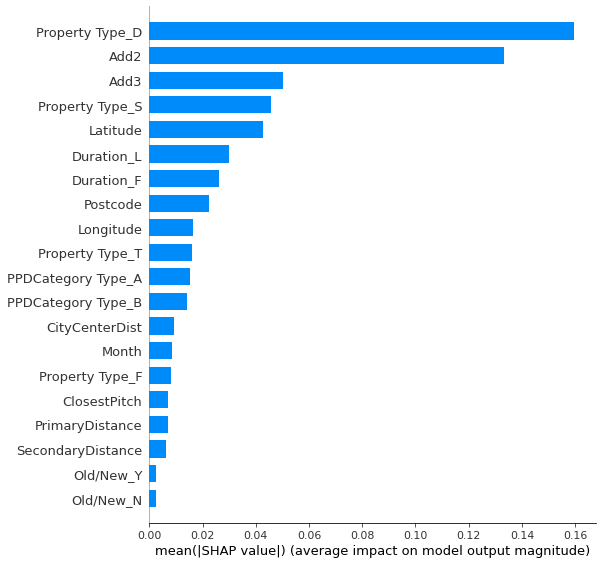

In [112]:
f = plt.figure()
shap.summary_plot(shap_values, x_test_21, plot_type = 'bar')
f.savefig("summary_plotleeds21.png", bbox_inches = 'tight', dpi = 600)

In [111]:
fig

In [36]:
cnames=['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df11 = pd.DataFrame(columns=cnames)

df11 = df11.append({'Algorithm': 'TPOT AutoML',
            'Year': 2021,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index=True)

In [37]:
dfreal1 = pd.DataFrame(y_test_21.values)
dfpred1 = pd.DataFrame(y_predicted_21)

### 2020

In [38]:
specific20 = irl[irl['Year'] > 2016]

In [39]:
test_20 = specific20[specific20['Year'] == 2020]
train_20 = specific20[specific20['Year'] < 2020]

x_train_20 = train_20.loc[:, train_20.columns != 'LogPrice (€)']
y_train_20 = train_20['LogPrice (€)']

x_test_20 = test_20.loc[:, test_20.columns != 'LogPrice (€)']
y_test_20 = test_20['LogPrice (€)']

In [40]:
x_t_20 = x_test_20

In [41]:
model = TPOTRegressor(max_time_mins = 6)
model2 = model.fit(x_train_20, y_train_20)

In [42]:
#model2.export('tpot_2020_pipeline.py')

In [43]:
y_predicted_20 = model1.predict(x_test_20)
  
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_20, y_predicted_20)
print('MSE for TPOT AutoML 2020 is: ' + str(mse))

MSE for TPOT AutoML 2020 is: 0.040499360021706884


In [44]:
from sklearn.metrics import mean_absolute_percentage_error
mape = mean_absolute_percentage_error(y_test_20, y_predicted_20)
print("MAPE for TPOT AutoML 2020 is: " + str(mape))

MAPE for TPOT AutoML 2020 is: 0.010114671718898868


In [45]:
median_se = np.square(np.subtract(y_test_20, y_predicted_20)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.08466122989072034


In [46]:
rmse = mean_squared_error(y_test_20, y_predicted_20, squared=False)
print('RMSE for TPOT AutoML 2020 is: ' + str(rmse))

RMSE for TPOT AutoML 2020 is: 0.2012445279298468


In [47]:
acc = accuracy_threshold(y_test_20, y_predicted_20, 0.1)

In [48]:
cnames=['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df12 = pd.DataFrame(columns=cnames)

df12 = df12.append({'Algorithm': 'TPOT AutoML',
            'Year': 2020,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index=True)

In [49]:
dfreal2 = pd.DataFrame(y_test_20.values)
dfpred2 = pd.DataFrame(y_predicted_20)

In [114]:
%%capture
explainer = shap.Explainer(model2.predict, x_test_20)
shap_values = explainer(x_test_20)

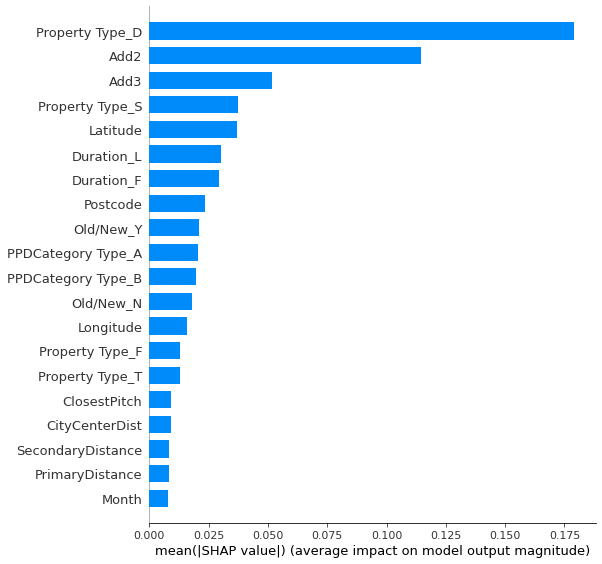

In [115]:
f = plt.figure()
shap.summary_plot(shap_values, x_test_20, plot_type = 'bar')
f.savefig("summary_plotleeds20.png", bbox_inches = 'tight', dpi = 600)

### 2019

In [51]:
specific19 = irl[irl['Year'] > 2015]

In [52]:
test_19 = specific19[specific19['Year'] == 2019]
train_19 = specific19[specific19['Year'] < 2019]
x_train_19 = train_19.loc[:, train_19.columns != 'LogPrice (€)']
y_train_19 = train_19['LogPrice (€)']
x_test_19 = test_19.loc[:, test_19.columns != 'LogPrice (€)']
y_test_19 = test_19['LogPrice (€)']

In [53]:
x_t_19 = x_test_19

In [54]:
model = TPOTRegressor(max_time_mins = 6)
# perform the search // takes ages to run!
model3 = model.fit(x_train_19, y_train_19)

In [55]:
#model3.export('tpot_2019_pipeline.py')

In [56]:
y_predicted_19 = model1.predict(x_test_19)
  
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_19, y_predicted_19)
print('MSE for TPOT AutoML 2019 is: ' + str(mse))

MSE for TPOT AutoML 2019 is: 0.04626213399165155


In [57]:
from sklearn.metrics import mean_absolute_percentage_error
mape = mean_absolute_percentage_error(y_test_19, y_predicted_19)
print("MAPE for TPOT AutoML 2019 is: " + str(mape))

MAPE for TPOT AutoML 2019 is: 0.01069157406387535


In [58]:
median_se = np.square(np.subtract(y_test_19, y_predicted_19)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.08262001885010743


In [59]:
rmse = mean_squared_error(y_test_19, y_predicted_19, squared = False)
print('RMSE for TPOT AutoML 2019 is: ' + str(rmse))

RMSE for TPOT AutoML 2019 is: 0.2150863407835364


In [60]:
acc = accuracy_threshold(y_test_19, y_predicted_19, 0.1)

In [116]:
%%capture
explainer = shap.Explainer(model3.predict, x_test_19)
shap_values = explainer(x_test_19)

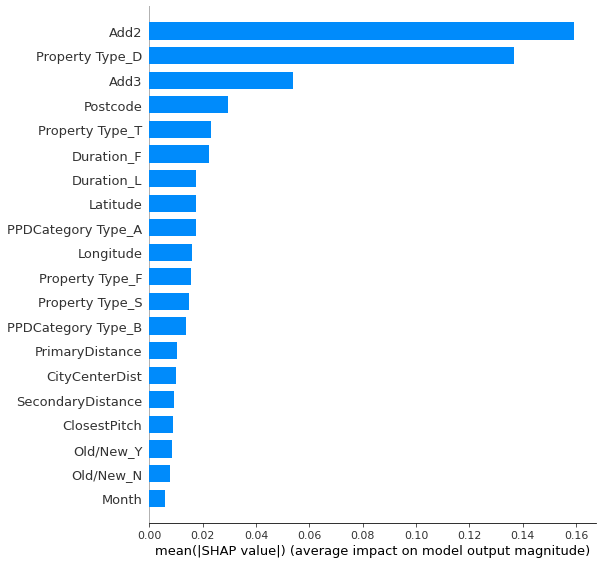

In [117]:
f = plt.figure()
shap.summary_plot(shap_values, x_test_19, plot_type = 'bar')
f.savefig("summary_plotleeds19.png", bbox_inches = 'tight', dpi = 600)

In [62]:
cnames=['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df13 = pd.DataFrame(columns = cnames)

df13 = df13.append({'Algorithm': 'TPOT AutoML',
            'Year': 2019,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index=True)

In [63]:
dfreal3 = pd.DataFrame(y_test_19.values)
dfpred3 = pd.DataFrame(y_predicted_19)

### 2018

In [64]:
specific18 = irl[irl['Year'] > 2014]
test_18 = specific18[specific18['Year'] == 2018]
train_18 = specific18[specific18['Year'] < 2018]

x_train_18 = train_18.loc[:, train_18.columns != 'LogPrice (€)']
y_train_18 = train_18['LogPrice (€)']
x_test_18 = test_18.loc[:, test_18.columns != 'LogPrice (€)']
y_test_18 = test_18['LogPrice (€)']

In [65]:
x_t_18 = x_test_18

In [66]:
model = TPOTRegressor(max_time_mins = 6)
# perform the search // takes ages to run!
model4 = model.fit(x_train_18, y_train_18)

In [67]:
#model4.export('tpot_2018_pipeline.py')

In [68]:
y_predicted_18 = model1.predict(x_test_18)
  
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_18, y_predicted_18)
print('MSE for TPOT AutoML 2018 is: ' + str(mse))

MSE for TPOT AutoML 2018 is: 0.03623937669395505


In [69]:
rmse = mean_squared_error(y_test_18, y_predicted_18, squared = False)
print('RMSE for TPOT AutoML 2018 is: ' + str(rmse))

RMSE for TPOT AutoML 2018 is: 0.19036642743392293


In [70]:
from sklearn.metrics import mean_absolute_percentage_error
mape = mean_absolute_percentage_error(y_test_18, y_predicted_18)
print("MAPE for TPOT AutoML 2018 is: " + str(mape))

MAPE for TPOT AutoML 2018 is: 0.008264219524500013


In [71]:
median_se = np.square(np.subtract(y_test_18, y_predicted_18)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.06125614991689599


In [72]:
acc = accuracy_threshold(y_test_18, y_predicted_18, 0.1)

In [120]:
%%capture
explainer = shap.Explainer(model4.predict, x_test_18)
shap_values = explainer(x_test_18)

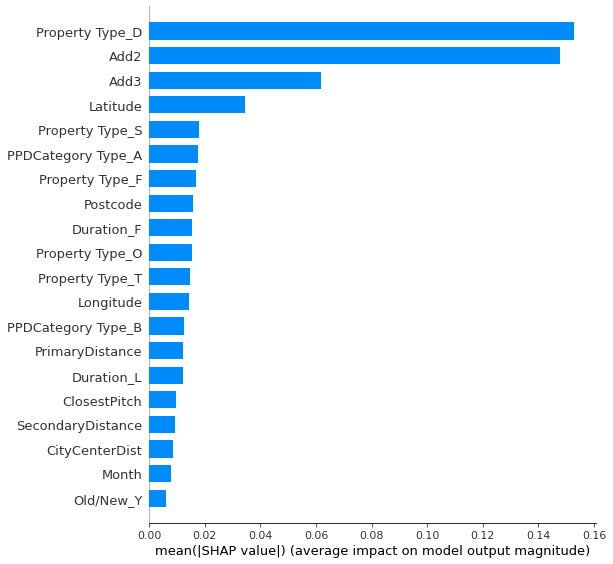

In [121]:
f = plt.figure()
shap.summary_plot(shap_values, x_test_18, plot_type = 'bar')
f.savefig("summary_plotleeds18.png", bbox_inches = 'tight', dpi = 600)

In [74]:
cnames=['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df14 = pd.DataFrame(columns=cnames)

df14 = df14.append({'Algorithm': 'TPOT AutoML',
            'Year': 2018,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index=True)

In [75]:
dfreal4 = pd.DataFrame(y_test_18.values)
dfpred4 = pd.DataFrame(y_predicted_18)

### 2017

In [76]:
specific17 = irl[irl['Year'] > 2013]
test_17 = specific17[specific17['Year'] == 2017]
train_17 = specific17[specific17['Year'] < 2017]

x_train_17 = train_17.loc[:, train_17.columns != 'LogPrice (€)']
y_train_17 = train_17['LogPrice (€)']
x_test_17 = test_17.loc[:, test_17.columns != 'LogPrice (€)']
y_test_17 = test_17['LogPrice (€)']

In [77]:
x_t_17 = x_test_17

In [78]:
model = TPOTRegressor(max_time_mins = 6)
# perform the search // takes ages to run!
model5 = model.fit(x_train_17, y_train_17)

In [79]:
#model5.export('tpot_2017_pipeline.py')

In [80]:
y_predicted_17 = model1.predict(x_test_17)
  
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_17, y_predicted_17)
print('MSE for TPOT AutoML 2017 is: ' + str(mse))

MSE for TPOT AutoML 2017 is: 0.09667156365173803


In [81]:
from sklearn.metrics import mean_absolute_percentage_error
mape = mean_absolute_percentage_error(y_test_17, y_predicted_17)
print("MAPE for TPOT AutoML 2017 is: " + str(mape))

MAPE for TPOT AutoML 2017 is: 0.01568534277486119


In [82]:
median_se = np.square(np.subtract(y_test_17, y_predicted_17)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.12536724860382442


In [83]:
rmse = mean_squared_error(y_test_17, y_predicted_17, squared=False)
print('RMSE for TPOT AutoML 2017 is: ' + str(rmse))

RMSE for TPOT AutoML 2017 is: 0.3109205101818438


In [84]:
acc = accuracy_threshold(y_test_17, y_predicted_17, 0.1)

In [122]:
%%capture
explainer = shap.Explainer(model5.predict, x_test_17)
shap_values = explainer(x_test_17)

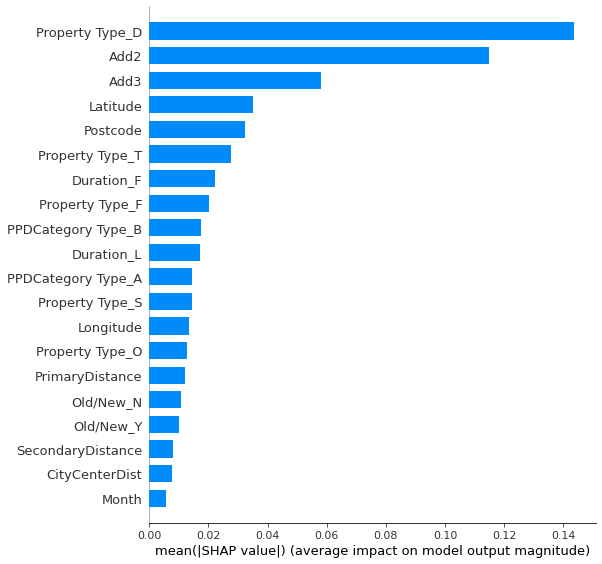

In [123]:
f = plt.figure()
shap.summary_plot(shap_values, x_test_17, plot_type = 'bar')
f.savefig("summary_plotleeds17.png", bbox_inches = 'tight', dpi = 600)

In [86]:
dfreal5 = pd.DataFrame(y_test_17.values)
dfpred5 = pd.DataFrame(y_predicted_17)

In [87]:
cnames=['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df15 = pd.DataFrame(columns=cnames)

df15 = df15.append({'Algorithm': 'TPOT AutoML',
            'Year': 2017,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index=True)

In [88]:
vis1 = pd.concat([df11, df12, df13, df14, df15], ignore_index=True)

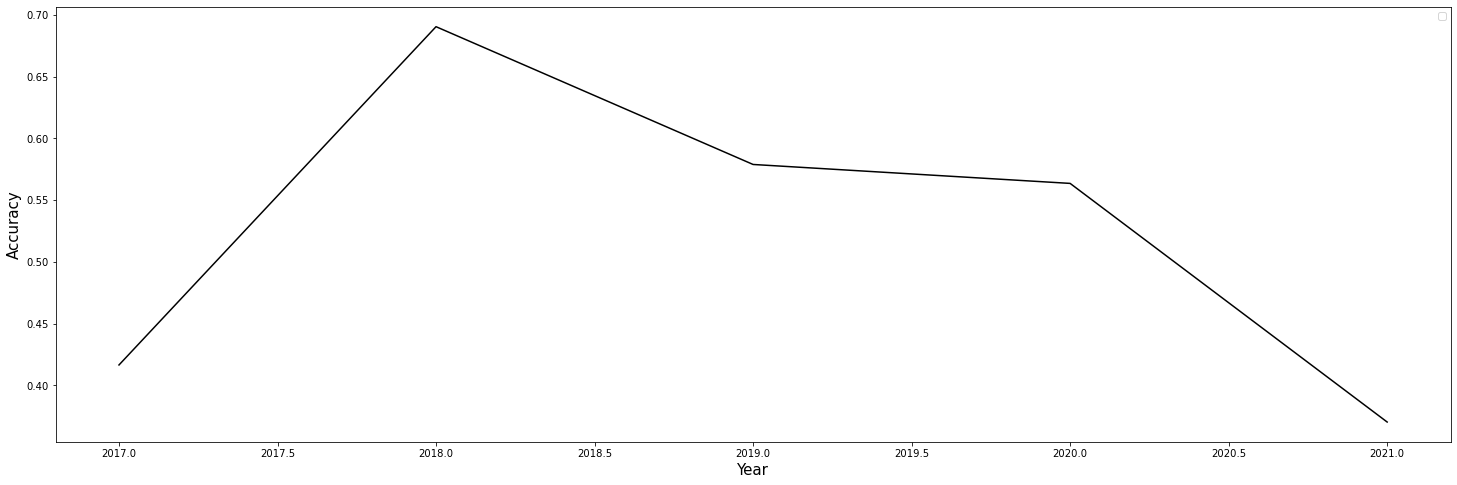

In [119]:
# don't need cross validation same training due to set intervals?
fig, ax = plt.subplots(figsize = (25, 8))
plt.plot(vis1['Year'], vis1['Accuracy'], color = 'black')
plt.xlabel('Year', fontsize = 15)
plt.ylabel('Accuracy', fontsize = 15)
#plt.title('TPOT AutoML Results 2017 - 2021')
plt.legend()
plt.show()

fig.savefig('performance-overtime-leedstpot.png', bbox_inches='tight')

In [90]:
print("Mean accuracy for TPOT AutoML over period 2017-2021 is: " + str(vis1['Accuracy'].mean()))

Mean accuracy for TPOT AutoML over period 2017-2021 is: 0.5239357019141636


In [91]:
actual = pd.concat([dfreal1, dfreal2, dfreal3, dfreal4, dfreal5], ignore_index = True)
actual.rename(columns = {0: 'Actual'}, inplace = True)
actual.head()

,Actual
0,12.823148
1,11.891362
2,13.681979
3,11.982929
4,11.652687


In [92]:
pred = pd.concat([dfpred1, dfpred2, dfpred3, dfpred4, dfpred5], ignore_index = True)
pred.rename(columns={0: 'Predicted'}, inplace = True)
pred.head()

,Predicted
0,12.748670
1,11.661945
2,13.255032
3,12.448281
4,11.619074


In [93]:
actualvpred = actual.join(pred)

In [94]:
actualvpred.head()

,Actual,Predicted
0,12.823148,12.748670
1,11.891362,11.661945
2,13.681979,13.255032
3,11.982929,12.448281
4,11.652687,11.619074


In [95]:
exp = np.exp(actualvpred)

In [96]:
exp.shape

(27414, 2)

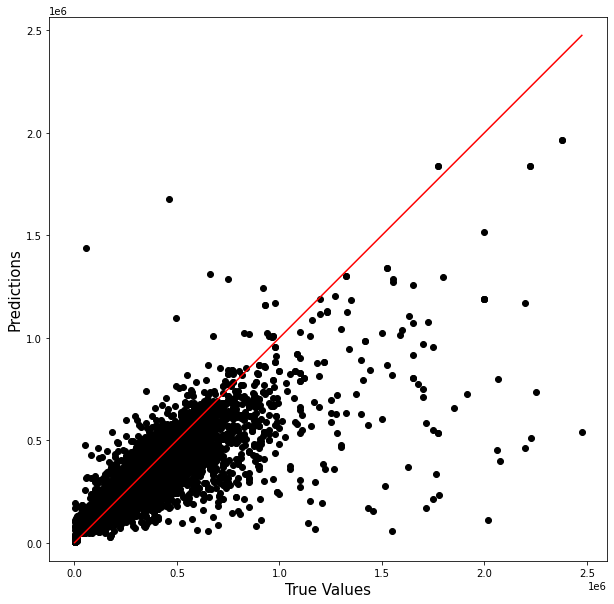

In [97]:
# plot predicted vs actual
## this is using actual prices hence adjusted scale compared to mljar plot
fig, ax = plt.subplots(figsize = (10, 10))
plt.scatter(exp['Actual'], exp['Predicted'], c = 'black')

p1 = max(max(exp['Predicted']), max(exp['Actual']))
p2 = min(min(exp['Predicted']), min(exp['Actual']))
plt.plot([p1, p2], [p1, p2], 'r-')
plt.xlabel('True Values', fontsize = 15)
plt.ylabel('Predictions', fontsize = 15)
#plt.title('TPOT AutoML Actual Vs Predicted Values')
plt.axis('equal')
plt.show()

fig.savefig('actualvpred-leedstpot.png', bbox_inches='tight')

In [98]:
x_t_21 = x_t_21.reset_index()
x_t_20 = x_t_20.reset_index()
x_t_19 = x_t_19.reset_index()
x_t_18 = x_t_18.reset_index()
x_t_17 = x_t_17.reset_index()

x_t_21.drop(columns = ['index'], inplace = True)
x_t_20.drop(columns = ['index'], inplace = True)
x_t_19.drop(columns = ['index'], inplace = True)
x_t_18.drop(columns = ['index'], inplace = True)
x_t_17.drop(columns = ['index'], inplace = True)

In [99]:
l1 = dfreal1.join(x_t_21[['Longitude', 'Latitude']])
l2 = dfreal2.join(x_t_20[['Longitude', 'Latitude']])
l3 = dfreal3.join(x_t_19[['Longitude', 'Latitude']])
l4 = dfreal4.join(x_t_18[['Longitude', 'Latitude']])
l5 = dfreal5.join(x_t_17[['Longitude', 'Latitude']])

plots = pd.concat([l1, l2, l3, l4, l5], ignore_index=True)
plots.head()

,0,Longitude,Latitude
0,12.823148,-1.58847,53.74855
1,11.891362,-1.61968,53.80770
2,13.681979,-1.65612,53.83972
3,11.982929,-1.47258,53.85191
4,11.652687,-1.44393,53.72532


In [100]:
plots.rename(columns = {0 : 'Actual'}, inplace = True)

In [101]:
plots.head()

,Actual,Longitude,Latitude
0,12.823148,-1.58847,53.74855
1,11.891362,-1.61968,53.80770
2,13.681979,-1.65612,53.83972
3,11.982929,-1.47258,53.85191
4,11.652687,-1.44393,53.72532


In [102]:
plotscomp = plots.join(pred)
plotscomp.head()

,Actual,Longitude,Latitude,Predicted
0,12.823148,-1.58847,53.74855,12.748670
1,11.891362,-1.61968,53.80770,11.661945
2,13.681979,-1.65612,53.83972,13.255032
3,11.982929,-1.47258,53.85191,12.448281
4,11.652687,-1.44393,53.72532,11.619074


In [103]:
exp1 = np.exp(plotscomp[['Actual', 'Predicted']])

In [104]:
exp1 = exp1.join(plotscomp[['Longitude', 'Latitude']])

In [105]:
exp1.head()

,Actual,Predicted,Longitude,Latitude
0,370700.0,344093.997683,-1.58847,53.74855
1,146000.0,116069.539008,-1.61968,53.80770
2,875000.0,570935.879925,-1.65612,53.83972
3,160000.0,254811.898251,-1.47258,53.85191
4,115000.0,111198.696022,-1.44393,53.72532
